<a href="https://colab.research.google.com/github/lucaspalomeque/python-binance/blob/master/fracdiff_binance_trades_ctf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MM Bot CTF  Baseline Operacion#

##1. Carga Datos y Preparado ##

In [134]:
%pip install ijson
%pip install json

import json  
import pandas as pd  
from pandas.io.json import json_normalize  

import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd

import numpy as np

  ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


Funciones para abrir los archivos al colab y preparar la informacion de binance

In [0]:
#esto es el codigo para subir cosas a google colab
def subir_archivo():
  from google.colab import files
  uploaded = files.upload()
  return uploaded

In [0]:
def abrir_trades_binance(name):
  import json  
  import pandas as pd  
  from pandas.io.json import json_normalize  


  
  with open(name) as f: 
      d = json.load(f) 
    
  trades = json_normalize(d['data']) 

  return trades
  
  #trades.head(3) 

In [0]:
#en base a info api binance websocket, trades

def renombrar_trades_binance(bdtrades):
  
  bdtrades.rename(columns={'E':'Event time','T':'Trade time','p':'price',
                         'q':'volume','M':'Ignore','a':'Seller order ID',
                         'b':'Buyer order ID','e':'event type','m':'MM Buyer','s':'Symbol','t':'Trade ID'}, inplace=True)


  trades.drop(['Ignore'],axis=1,inplace=True)
  trades['Trade time'] = pd.to_datetime(trades['Trade time'], unit='ms')
  trades['Event time']=pd.to_datetime(trades['Event time'], unit='ms')
  trades['price'] = trades['price'].astype(float)
  trades['volume'] = trades['volume'].astype(float)
  
  return trades

In [5]:
##correrlo dos veces
subir_archivo()

Saving binance-BNBBTC-2019-5-10 00_51_49.json to binance-BNBBTC-2019-5-10 00_51_49.json


{'binance-BNBBTC-2019-5-10 00_51_49.json': b'{"data":[{"e":"trade","E":1557445911544,"s":"BNBBTC","t":44511851,"p":"0.00303070","q":"0.61000000","b":160432482,"a":160432492,"T":1557445911539,"m":true,"M":true},{"e":"trade","E":1557445913520,"s":"BNBBTC","t":44511852,"p":"0.00303070","q":"11.16000000","b":160432482,"a":160432495,"T":1557445913514,"m":true,"M":true},{"e":"trade","E":1557445913520,"s":"BNBBTC","t":44511853,"p":"0.00303070","q":"11.77000000","b":160432485,"a":160432495,"T":1557445913514,"m":true,"M":true},{"e":"trade","E":1557445913520,"s":"BNBBTC","t":44511854,"p":"0.00303070","q":"5.60000000","b":160432490,"a":160432495,"T":1557445913514,"m":true,"M":true},{"e":"trade","E":1557445913520,"s":"BNBBTC","t":44511855,"p":"0.00303060","q":"11.77000000","b":160432480,"a":160432495,"T":1557445913514,"m":true,"M":true},{"e":"trade","E":1557445913520,"s":"BNBBTC","t":44511856,"p":"0.00303060","q":"10.70000000","b":160432494,"a":160432495,"T":1557445913514,"m":true,"M":true},{"e":"

In [138]:
trades = abrir_trades_binance('binance-BNBBTC-2019-5-10 00_51_49.json')
trades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8075 entries, 0 to 8074
Data columns (total 11 columns):
E    8075 non-null int64
M    8075 non-null bool
T    8075 non-null int64
a    8075 non-null int64
b    8075 non-null int64
e    8075 non-null object
m    8075 non-null bool
p    8075 non-null object
q    8075 non-null object
s    8075 non-null object
t    8075 non-null int64
dtypes: bool(2), int64(5), object(4)
memory usage: 583.6+ KB


Una vez que esto se consiga para todos los exchanges estandarizar y automatizar podremos pasar a la etapa de preparacion de OHLC 

In [139]:
trades=renombrar_trades_binance(trades)
trades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8075 entries, 0 to 8074
Data columns (total 10 columns):
Event time         8075 non-null datetime64[ns]
Trade time         8075 non-null datetime64[ns]
Seller order ID    8075 non-null int64
Buyer order ID     8075 non-null int64
event type         8075 non-null object
MM Buyer           8075 non-null bool
price              8075 non-null float64
volume             8075 non-null float64
Symbol             8075 non-null object
Trade ID           8075 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(2), int64(3), object(2)
memory usage: 575.7+ KB


A futuro tenemos que implementar las diferentes series de tiempo necesarias para realizar las implementaciones de Volume y Dollar Bars. Entre otras medidas

In [0]:
# Esto falta hacerlo andar. 
def crear_OHLC_5S(trades):
  
  #trade time como index
  df = trades.set_index('Trade time')
  
  #resampleo de datos de precio a 5s
  df_prueba = df['price'].resample('5S').ohlc() #crear calculo personal de ohlc
  
  #resampleo de datos de volumen en 5s. Pero tomaremos la sumatoria de precios como el
  df_prueba_volumen = df['volume'].resample('5S').sum()
  df_prueba_volumen_ohlc = df['volume'].resample('5S').sum()
  df_prueba['volume']= df_prueba_volumen
  df_prueba.info()

Hay que encontrar un calculo para el VWAP que puede ayudar para el sizing de las ordenes y para leer el mercado. Necesitamos entender toda la informacion a extraer de un dataset de trades con el volumen y el side. 

In [0]:
#seguir trabajando en esto
def vwap(df):
    #todavia hay que pensar como llenar los nans para que no afecten el calculo
    df_prueba.fillna(method='bfill',inplace=True) 
  
    q = df_prueba.volume.values
    p = df_prueba.close.values
    return df.assign(vwap=(p * q).cumsum() / q.cumsum())

df2 = df.groupby(df.index.date, group_keys=False).apply(vwap)
df2


#df = df.assign(
#    vwap=df.eval(
#        'wgtd = price * quantity', inplace=False
#    ).groupby(df.index.date).cumsum().eval('wgtd / quantity')
#)
#df

## Extraccion de Features ## 

Para la realizacion de la extraccion de Features  trabajaremos con samples de 5s (hay que pensar como vamos a mejorar estos tiempos, que metodo de optimizacion nos puede ayudar a mejorar los tiempos)

###Diferenciacion Fraccional###

Vamos a separar los trades en OHLCs de 5s para despues realizar un analsis de estacionalidad sobre los retornos para poder asi entender una posible estacionalidad lo cual implica una regresion a la media. 

In [140]:
df = trades.set_index('Trade time')
df_prueba = df['price'].resample('5S').ohlc()
df_prueba_volumen = df['volume'].resample('5S').sum()
df_prueba['volume']= df_prueba_volumen
df_prueba.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2019-05-09 23:51:50 to 2019-05-10 00:51:45
Freq: 5S
Data columns (total 5 columns):
open      673 non-null float64
high      673 non-null float64
low       673 non-null float64
close     673 non-null float64
volume    720 non-null float64
dtypes: float64(5)
memory usage: 33.8 KB


Hay diferentes metodos para llenar los Nans. Cuales son convenientes para series de tiempo de precios? 

In [0]:
#todavia hay que pensar como llenar los nans para que no afecten el calculo
df_prueba.fillna(method='bfill',inplace=True) 


In [0]:
df_prueba['close'] = df_prueba['close'].astype(float)
df_prueba['open'] = df_prueba['open'].astype(float)
df_prueba['low'] = df_prueba['low'].astype(float)
df_prueba['high'] = df_prueba['high'].astype(float)

#el retorno nos da una medida estacionaria Base 
df_prueba['retorno']= df_prueba['close'] / df_prueba['close'].shift(1) - 1


In [143]:
df_prueba.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2019-05-09 23:51:50 to 2019-05-10 00:51:45
Freq: 5S
Data columns (total 6 columns):
open       720 non-null float64
high       720 non-null float64
low        720 non-null float64
close      720 non-null float64
volume     720 non-null float64
retorno    719 non-null float64
dtypes: float64(6)
memory usage: 39.4 KB


Cuando empezamos a checkiar los retornos vemos que tienen un comportamiento que a priori parece estacionario

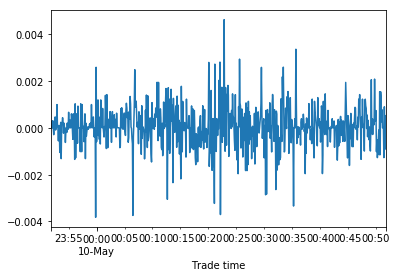

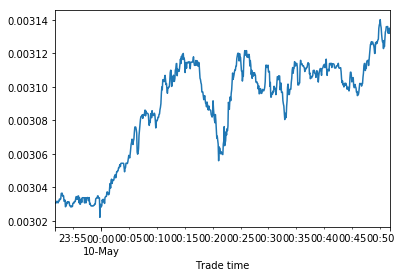

In [144]:
from matplotlib import pyplot

df_prueba['retorno'].plot()
pyplot.show()
df_prueba['close'].plot()
pyplot.show()

Al aplicar el tests de adfuller podemos encontrar los valores para este test que determina la estacionalidad de una serie de numeros. 

In [146]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller

df_prueba['retorno'].fillna(method='bfill',inplace=True) 

X = df_prueba['retorno'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -27.589203
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


Lo que vemos es que lo cumple pero esta transformacion al verl asobre la lupa nos da valores muy dispares. 

Al separar la seire de tiempo en dos vemos que los valores de la media difieren muchisimo. 

In [147]:
x =len(df_prueba)
split = x//2
df_prueba2 = df_prueba.reset_index()
len(df_prueba2)
X = df_prueba2['retorno']
split = len(X) // 2
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))


mean1=0.000027, mean2=0.000068
variance1=0.000001, variance2=0.000001


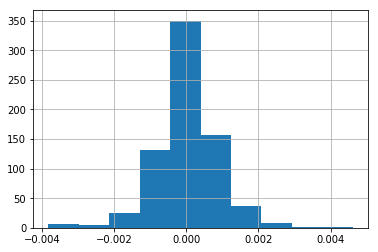

In [148]:
df_prueba2['retorno'].hist()
pyplot.show()

Probaremos ahora que pasa cuando alplicamos una transformacion logaritmica a nuestros datos. 

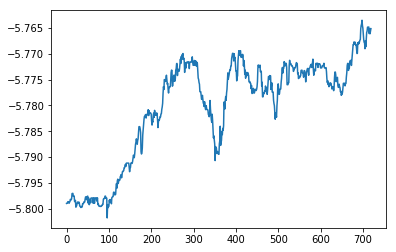

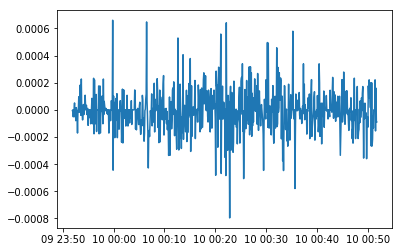

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


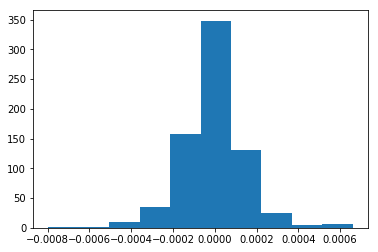

In [149]:
from numpy import log

X = df_prueba['close'].values
X = log(X)
df_prueba['close_log'] = X.astype(float)
df_prueba['retorno_log']= df_prueba['close_log'] / df_prueba['close_log'].shift(1) - 1

pyplot.plot(X)
pyplot.show()
pyplot.plot(df_prueba["retorno_log"])
pyplot.show()
pyplot.hist(df_prueba['retorno_log'])
pyplot.show()


Al revisar la media de los retornos vemos una mejora pero no muy notoria 

In [150]:
#todavia hay que pensar como llenar los nans para que no afecten el calculo
df_prueba['retorno_log'].fillna(method='bfill',inplace=True) 

X = df_prueba['retorno_log'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -27.584906
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


Las medias sin embargo estan mas cercanas

In [151]:
x =len(df_prueba)
split = x//2
df_prueba2 = df_prueba.reset_index()
len(df_prueba2)
X = df_prueba2['retorno_log']
split = len(X) // 2
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))


mean1=-0.000005, mean2=-0.000012
variance1=0.000000, variance2=0.000000


Para poder realizar un analisis mas profesional de los datos aplicaremos una tecnica conocida como Difrencia Fraccional con la cual se busca realizar una transformacion de los datos que pierda menos informacion que lo que se ve al aplicar solamente los retornos

In [0]:
#codigo para definir los pesos
def getWeights(d,size):
  import numpy as np

  # thres >0 drops insignificant weights
  w =[1.]
  for k in range(1,size):
    
    w_=-w[-1]/k*(d-k+1)
    w.append(w_)
  w_np = np.array(w, dtype=np.float64)
  w_np= w_np[::-1].reshape(-1,1)
  return w_np

In [0]:
#codigo para plotearlos
def plotWeights(dRange,nPlots,size):
  w=pd.DataFrame()
  for d in np.linspace(dRange[0],dRange[1],nPlots):
    w_=getWeights(d,size=size)
    w_=pd.DataFrame(w_,index=range(w_.shape[0])[::-1],columns=[d])
    w=w.join(w_,how='outer')
  ax=w.plot()
  ax.legend(loc='upper left');plt.show()
  return

En la prueba de abajo vemos como van variando los pesos varian en su convergencia. Entro 0 y 1 son los comportamientos que parecen ser mas "normales", de un rango de 1 para arriba estariamos en la presencia de una burbuja. 

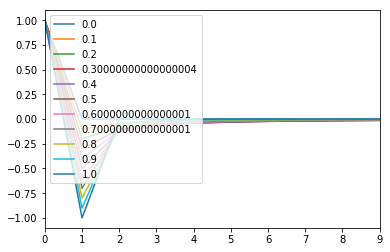

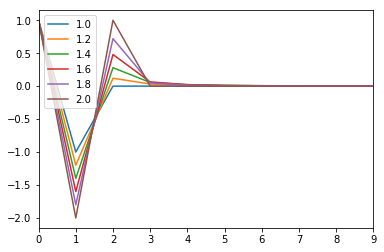

In [154]:
#Prueba
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

if __name__=='__main__':
  plotWeights(dRange=[0,1],nPlots=11,size=10)
  plotWeights(dRange=[1,2],nPlots=6,size=10)

In [0]:
import matplotlib as mpl


In [0]:
def fracDiff(series,d,thres=0.1):
  '''
  aumentando con widht window, con tratamiento de NaNs
  Nota 1: para thres=1 , no se skipea nada
  Nota 2: d puede ser cualquier fraccional positivo, no necesariamente entre [0,1]
  '''
  #1) computar los pesos para la serie mas larga
  
  w=getWeights(d,series.shape[0])
  plotWeights(dRange=[0,d],nPlots=11,size=10)
  #2) Determinar los calculos iniciales a skypearse basado en el weight loss thres
  
  w_=np.cumsum(abs(w))
  w_/=w_[-1]
  skip=w_[w_>thres].shape[0]
  
  #3) aplicar los pesos a los valores
  
  df={}
  for name in series.columns:
    seriesF,df_=series[[name]].fillna(method="ffill").dropna(),pd.Series()
    
    for iloc in range(skip,seriesF.shape[0]):
      loc=seriesF.index[iloc]
      if not np.isfinite(series.loc[loc,name]):continue #excluir Nans
      df_[loc]=np.dot(w[-(iloc+1):,:].T,seriesF.loc[:loc])[0,0]
    df[name]=df_.copy(deep=True)
  df=pd.concat(df,axis=1)
  return df

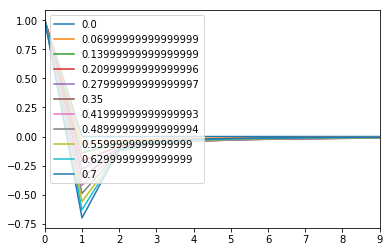

In [157]:
df_frac=fracDiff(df_prueba,0.7,thres=0.1)

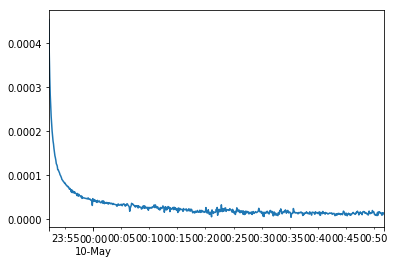

In [158]:
df_frac['close'].plot()

In [159]:
#todavia hay que pensar como llenar los nans para que no afecten el calculo
df_frac['close'].fillna(method='bfill',inplace=True) 

X = df_frac['close'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.313651
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


Ganamos una serie "estacional" pero perdimos todas las propiedades gaussianas. Esto va a hacer que algunos analisis sobre esta data no se puedan performar tan facil. 

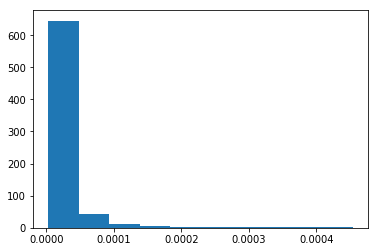

In [160]:
pyplot.hist(df_frac['close'])
pyplot.show()

In [161]:
x =len(df_frac)
split = x//2
df_prueba2 = df_frac.reset_index()
len(df_prueba2)
X = df_prueba2['close']
split = len(X) // 2
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))


mean1=0.000043, mean2=0.000014
variance1=0.000000, variance2=0.000000


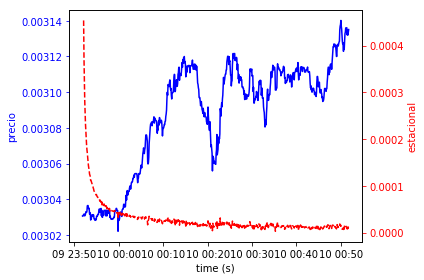

In [162]:

import numpy as np
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
t = df_prueba['close']
s1 = df_frac['close']
ax1.plot(t,'b-')
ax1.set_xlabel('time (s)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('precio', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()

ax2.plot(s1,'r--')
ax2.set_ylabel('estacional', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

In [0]:
def getWeights_FFD(d,thres):
  import numpy as np

  # thres >0 drops insignificant weights
  w =[1.]
  for k in np.arange(1,thres):
    
    w_=-w[-1]/k*(d-k+1)
    w.append(w_)
  w_np = np.array(w, dtype=np.float64)
  w_np= w_np[::-1].reshape(-1,1)
  return w_np

In [0]:
def plotWeights_FFD(dRange,nPlots,size):
  w=pd.DataFrame()
  for d in np.linspace(dRange[0],dRange[1],nPlots):
    w_=getWeights_FFD(d,thres=1e-5)
    w_=pd.DataFrame(w_,index=range(w_.shape[0])[::-1],columns=[d])
    w=w.join(w_,how='outer')
  ax=w.plot()
  ax.legend(loc='upper left');plt.show()
  return

In [0]:
def fracDiff_FFD(series,d,thres=1e-5):
  '''
  Widht Window Constante
  Nota1: el thres determina el cut off weight de la ventana
  Nota2: d puede ser cualquier fraccional positivo, no necesariamente [0:1]
  '''
  import pandas as pd
  #1) Computar los pesos para la serie mas larga
  w=getWeights_FFD(d,thres)
  width=len(w)-1

  plotWeights_FFD(dRange=[0,d],nPlots=11,size=10)
  
  #2) Apply weights to values
  df={}
  
  for name in series.columns:
    seriesF,df=series[[name]].fillna(method='ffill').dropna().pd.Series()
    loc0,loc1=seriesF.index[iloc1-width],seriesF.index[iloc1]
    if not np.isfinite(series.loc[loc1,name]):continue #excluir Nans
    df_[loc1]=np.dot(w,T.seriesF.loc[loc0:loc1])[0,0]
  df[name]=df.copy(deep=True)
  df=pd.concat(df,axis=1)
  return df

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1001: Us

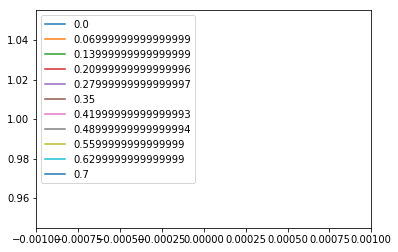

AttributeError: ignored

In [167]:
prueba2 = fracDiff_FFD(df_frac,0.7,thres=1e-5)

In [168]:
prueba2['close'].plot()

NameError: ignored